In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Check for GPU

In [2]:
if tf.config.list_physical_devices('GPU'):
    print('GPU FOUND:')
    !nvidia-smi -L
else:
    print('GPU NOT FOUND')

GPU FOUND:
GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-1370d395-71e0-4cca-5b97-9123148fb80f)


# Creation of some helper functions

In [3]:
def preprocess_images(image, label, shape=(224,224)):
    img = tf.image.resize(image, shape)
    img = img/255.
    return tf.cast(img, tf.float32), label

In [4]:
def resize_only(image, label, shape=(224,224)):
    img = tf.image.resize(image, shape)
    return tf.cast(img, tf.float32), label

In [5]:
def plot_curves(model_history):
    train_acc=model_history.history['accuracy']
    val_acc=model_history.history['val_accuracy']
    
    train_loss=model_history.history['loss']
    val_loss=model_history.history['val_loss']
    
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.plot(epochs,train_acc, label='train acc')
    plt.plot(epochs,val_acc, label='val_acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Loss')
    plt.plot(epochs,train_loss, label='train_loss')
    plt.plot(epochs,val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Load  horses vs humans dataset

In [6]:
#Check if dataset is available
target_dataset = 'beans'
if target_dataset in tfds.list_builders():
    print('Dataset available')
else:
    print('Dataset not found')

Dataset available


In [7]:
# Load dataset
(train_data,val_data, test_data), ds_info = tfds.load(target_dataset,
                                            as_supervised=True,
                                            with_info=True,
                                            split=['train','validation','test'],
                                            shuffle_files=True)

# Data study

In [8]:
# Dataset classes
classes = ds_info.features['label'].names
classes

['angular_leaf_spot', 'bean_rust', 'healthy']

In [9]:
# Visualize some information from a training sample
train_sample = train_data.take(1)
for image, label in train_sample:
    print('-'*10,'Image','-'*10)
    print(f'Image dtype:{image.dtype}\nImage shape:{image.shape}\nMin value:{tf.reduce_min(image)}\nMax value:{tf.reduce_max(image)}')
    print('-'*10,'Label','-'*10)
    print(f'Label dtype:{label.dtype}\nLabel:{label}\nLabel str form:{classes[label]}')

---------- Image ----------
Image dtype:<dtype: 'uint8'>
Image shape:(500, 500, 3)
Min value:0
Max value:255
---------- Label ----------
Label dtype:<dtype: 'int64'>
Label:1
Label str form:bean_rust


In [10]:
# Check how many samples in training, validation and  test sets
len(train_data), len(val_data), len(test_data)

(1034, 133, 128)

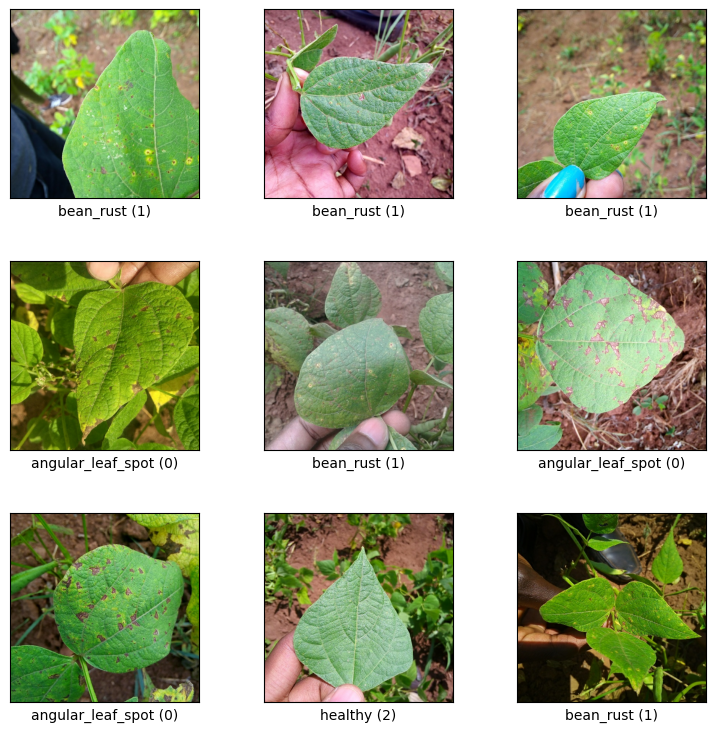

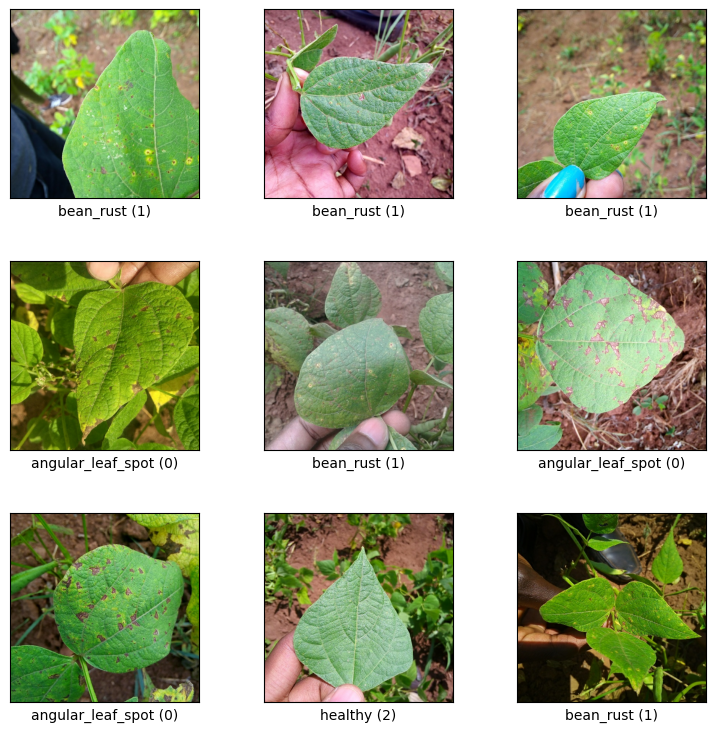

In [11]:
#Visualize some images
tfds.visualization.show_examples(
    ds = train_data,
    ds_info = ds_info
)

# Preprocess data

In [12]:
#Apply function to all images and parallelize
train_data = train_data.map(map_func=preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle data, batch it, and prefetch if for faster load
train_data = train_data.shuffle(buffer_size=500).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
#Same steps with the validation data
val_data = val_data.map(map_func=preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.shuffle(buffer_size=500).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Same for test data, except for the shuffle step
test_data = test_data.map(map_func=preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# Setup mixed precision training

In [14]:
#Check current mixed precision
print('Current mixed precision:',tf.keras.mixed_precision.global_policy())

Current mixed precision: <Policy "float32">


In [15]:
#Set mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [16]:
#Check current mixed precision after set global policy
print('Current mixed precision:',tf.keras.mixed_precision.global_policy())

Current mixed precision: <Policy "mixed_float16">


# Setup some constant variables

In [17]:
INPUT_SHAPE=(224,224,3)

# Create a baseline model

In [18]:
# Create a model
model_0 = Sequential([
    layers.Conv2D(filters=10, kernel_size=3, input_shape=INPUT_SHAPE),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(len(classes), activation='softmax')
])

In [19]:
# Compile the model
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [20]:
#Fit the model
model_0_history = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

Epoch 1/5
33/33 [==============================] - 4s 26ms/step - loss: 12.5016 - accuracy: 0.4188 - val_loss: 2.4116 - val_accuracy: 0.5639
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 1.3077 - accuracy: 0.6876 - val_loss: 0.8930 - val_accuracy: 0.6992
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 0.6343 - accuracy: 0.7747 - val_loss: 0.7132 - val_accuracy: 0.7143
Epoch 4/5
33/33 [==============================] - 1s 20ms/step - loss: 0.4196 - accuracy: 0.8433 - val_loss: 0.6815 - val_accuracy: 0.7368
Epoch 5/5
33/33 [==============================] - 1s 19ms/step - loss: 0.2931 - accuracy: 0.9101 - val_loss: 0.7304 - val_accuracy: 0.7519


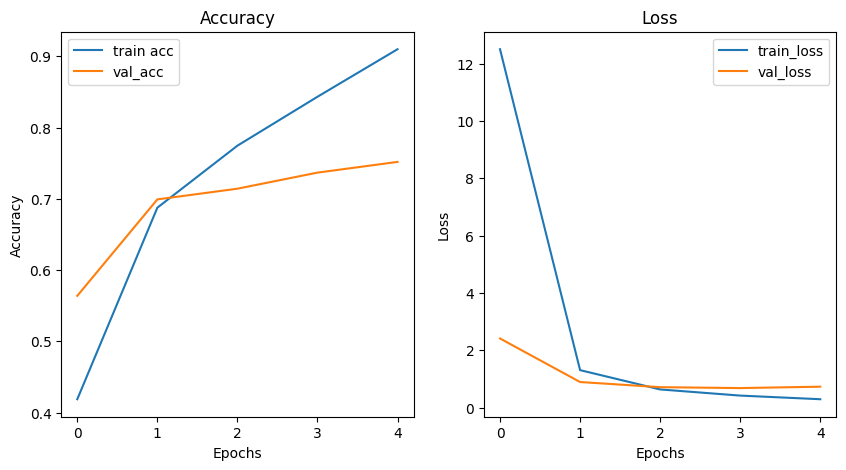

In [21]:
# Visualize training curves
plot_curves(model_0_history)

In [22]:
#Evaluate the model
model_0_results = model_0.evaluate(test_data)
model_0_results

4/4 [==============================] - 0s 9ms/step - loss: 0.7898 - accuracy: 0.7188


[0.789794921875, 0.71875]

# Using a feature extraction model

##### Loadded data again and applied only a resize function because feature extraction models like efficient net have builtin normalization

In [23]:
# Load dataset again
(train_data,val_data, test_data), ds_info = tfds.load(target_dataset,
                                            as_supervised=True,
                                            with_info=True,
                                            split=['train','validation','test'],
                                            shuffle_files=True)

In [24]:
#Apply function to all images and parallelize
train_data = train_data.map(map_func=resize_only, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle data, batch it, and prefetch if for faster load
train_data = train_data.shuffle(buffer_size=500).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
#Same steps with the validation data
val_data = val_data.map(map_func=resize_only, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.shuffle(buffer_size=500).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Same for test data, except for the shuffle step
test_data = test_data.map(map_func=resize_only, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# Create a base model
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False)
base_model.trainable=False #Freeze all model layers
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = base_model(inputs, training=False)# set base model in inference mode
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(classes), name='dense_layer')(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_activation_layer')(x) 
model_1 = tf.keras.Model(inputs, outputs)

In [26]:
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [27]:
model_1_history = model_1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

Epoch 1/5
33/33 [==============================] - 11s 206ms/step - loss: 0.8441 - accuracy: 0.6393 - val_loss: 0.6014 - val_accuracy: 0.8195
Epoch 2/5
33/33 [==============================] - 5s 159ms/step - loss: 0.5759 - accuracy: 0.7853 - val_loss: 0.4511 - val_accuracy: 0.8722
Epoch 3/5
33/33 [==============================] - 5s 159ms/step - loss: 0.4627 - accuracy: 0.8424 - val_loss: 0.3725 - val_accuracy: 0.8947
Epoch 4/5
33/33 [==============================] - 5s 160ms/step - loss: 0.3924 - accuracy: 0.8820 - val_loss: 0.3219 - val_accuracy: 0.9173
Epoch 5/5
33/33 [==============================] - 5s 160ms/step - loss: 0.3455 - accuracy: 0.8994 - val_loss: 0.2905 - val_accuracy: 0.9323


In [28]:
#Evaluate the model
model_1_results = model_1.evaluate(test_data)
model_1_results

4/4 [==============================] - 1s 130ms/step - loss: 0.3613 - accuracy: 0.8906


[0.36127549409866333, 0.890625]

## Fine tune

In [29]:
#unfreeze all model layers
base_model.trainable=True

In [30]:
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [31]:
model_1_history_fine_tune = model_1.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=model_1_history.epoch[-1])

Epoch 5/10
33/33 [==============================] - 20s 270ms/step - loss: 0.2705 - accuracy: 0.8907 - val_loss: 0.0904 - val_accuracy: 0.9774
Epoch 6/10
33/33 [==============================] - 8s 232ms/step - loss: 0.0528 - accuracy: 0.9865 - val_loss: 0.0655 - val_accuracy: 0.9699
Epoch 7/10
33/33 [==============================] - 8s 233ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.1154 - val_accuracy: 0.9699
Epoch 8/10
33/33 [==============================] - 8s 233ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9699
Epoch 9/10
33/33 [==============================] - 8s 233ms/step - loss: 7.5096e-04 - accuracy: 1.0000 - val_loss: 0.0810 - val_accuracy: 0.9699
Epoch 10/10
33/33 [==============================] - 8s 230ms/step - loss: 4.2578e-04 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 0.9624


In [32]:
#Evaluate the model
model_1_results = model_1.evaluate(test_data)
model_1_results

4/4 [==============================] - 1s 141ms/step - loss: 0.1460 - accuracy: 0.9531


[0.14599967002868652, 0.953125]

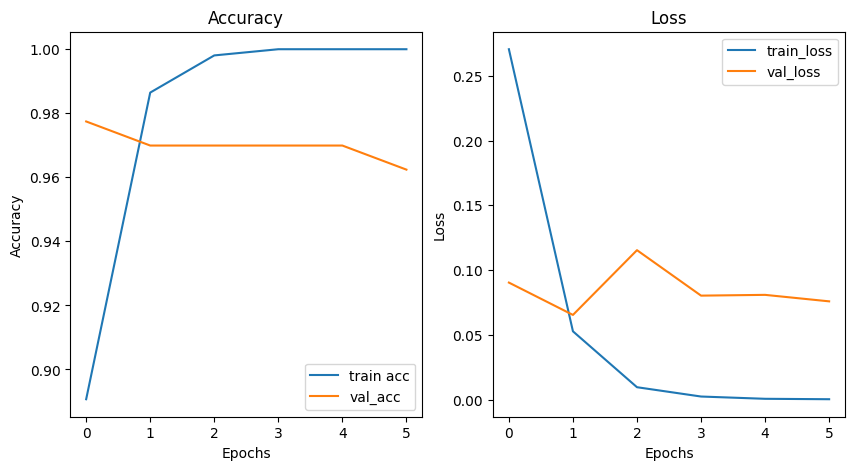

In [33]:
# plot training curves
plot_curves(model_1_history_fine_tune)

# Save model

In [ ]:
model_1.save('EfficientNetB0_beans')